In [8]:
import json
import sys
import os
srcdir = f"{os.getcwd()}/python"
if srcdir not in sys.path:
    sys.path.insert(0, srcdir)
    
import uproot
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

from utils import VBSConfig
import ingress
import train

In [9]:
# config = VBSConfig.from_json("configs/Gaussians3D_PRL.json")
# config = VBSConfig.from_json("configs/Gaussians3D_PRL_Baseline.json")
# config = VBSConfig.from_json("configs/Gaussians3D_PRL_posCov.json")
config = VBSConfig.from_json("configs/Gaussians3D_PRL_dCorr.json")

EPOCH = 100

train.get_outfile(config, epoch=EPOCH, tag="test", ext="csv")

'/blue/p.chang/jguiang/data/vbsvvh/Gaussians3D_PRL_dCorr/Gaussians3D_PRL_dCorr_modelNeuralNetwork_nhidden3_hiddensize128_lrConstantLR0.001_discolambda1000_epoch100_test.csv'

In [10]:
test_df = pd.read_csv(train.get_outfile(config, epoch=EPOCH, tag="test_inferences", ext="csv", subdir="inferences"))
train_df = pd.read_csv(train.get_outfile(config, epoch=EPOCH, tag="train_inferences", ext="csv", subdir="inferences"))
with open(train.get_outfile(config, tag="history", ext="json")) as f:
    history_json = json.load(f)

In [11]:
test_df.weight.sum()

600000.0

In [12]:
total_df = pd.concat([test_df, train_df])

total_sig = total_df[total_df.truth == 1].weight.sum()
total_bkg = total_df[total_df.truth == 0].weight.sum()
print(total_sig, total_bkg)

total_df

2000000.0 2000000.0


,idx,truth,score,weight
0,0,1,0.501073,1.0
1,1,1,0.813156,1.0
2,2,1,0.734091,1.0
3,3,1,0.917413,1.0
4,4,1,0.882775,1.0
...,...,...,...,...
3399995,3399995,0,0.141690,1.0
3399996,3399996,0,0.171013,1.0
3399997,3399997,0,0.127781,1.0
3399998,3399998,0,0.359442,1.0


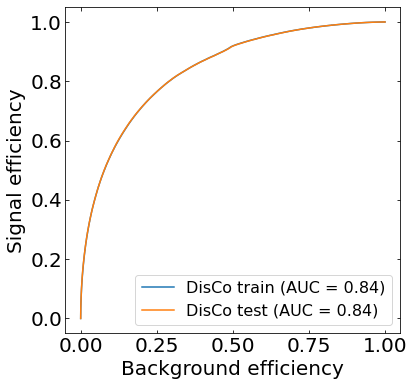

In [13]:
fig, axes = plt.subplots(figsize=(6,6))

# Plot training ROC curve
fpr, tpr, thresh = roc_curve(train_df.truth, train_df.score)
axes.plot(fpr, tpr, label=f"DisCo train (AUC = {np.trapz(tpr, fpr):.2f})");

# Plot testing ROC curve
fpr, tpr, thresh = roc_curve(test_df.truth, test_df.score)
axes.plot(fpr, tpr, label=f"DisCo test (AUC = {np.trapz(tpr, fpr):.2f})");

# Format axes
axes.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
axes.set_xlabel("Background efficiency", size=20);
axes.set_ylabel("Signal efficiency", size=20);
axes.legend(fontsize=16);

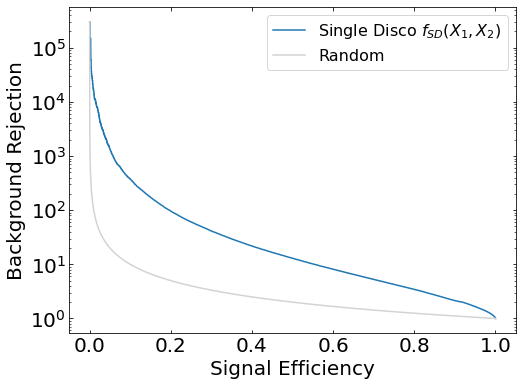

In [14]:
def inv_fpr(fpr, n_bkg):
    inv_fpr = np.zeros(fpr.shape)
    inv_fpr[fpr >  0] = 1/fpr[fpr > 0]
    inv_fpr[fpr == 0] = n_bkg
    return inv_fpr


fig, axes = plt.subplots(figsize=(8,6))

# Plot testing ROC curve
fpr, tpr, thresh = roc_curve(test_df.truth, test_df.score)
n_bkg = np.sum(~test_df.truth.astype(bool))

axes.plot(tpr, inv_fpr(fpr, n_bkg), label=r"Single Disco $f_{SD}(X_1, X_2)$");

tpr = np.linspace(0, 1, n_bkg)
fpr = np.linspace(0, 1, n_bkg)
axes.plot(tpr, inv_fpr(fpr, n_bkg), color="lightgrey", label="Random")

# axes.plot(tpr, fpr, color="lightgrey", label="Random")

# Format axes
axes.set_ylabel("Background Rejection", size=20);
axes.set_xlabel("Signal Efficiency", size=20);
axes.set_yscale("log")
axes.autoscale()
axes.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
axes.legend(fontsize=16);

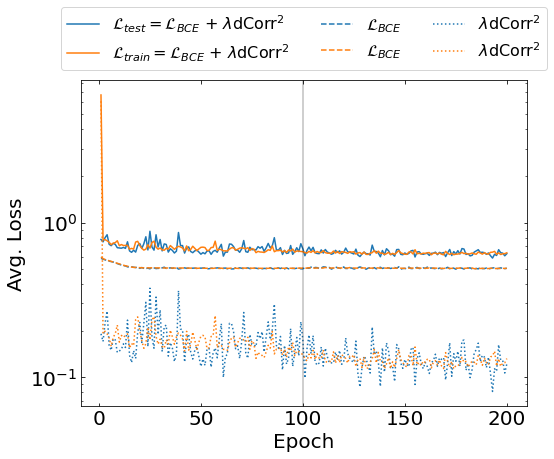

In [15]:
fig, axes = plt.subplots(figsize=(8, 6))

epochs = range(1, len(history_json["train_loss"])+1)

N = 1 # granularity of epochs shown (every Nth epoch is plotted)
axes.plot(epochs[::N], history_json["test_loss"][::N], label=r"$\mathcal{L}_{test} = \mathcal{L}_{BCE}$ + $\lambda$dCorr$^2$", color="C0");
axes.plot(epochs[::N], history_json["train_loss"][::N], label=r"$\mathcal{L}_{train} = \mathcal{L}_{BCE}$ + $\lambda$dCorr$^2$", color="C1");
axes.plot(epochs[::N], history_json["test_bce"][::N], label=r"$\mathcal{L}_{BCE}$", color="C0", linestyle="dashed")
axes.plot(epochs[::N], history_json["train_bce"][::N], label=r"$\mathcal{L}_{BCE}$", color="C1", linestyle="dashed")
axes.plot(epochs[::N], history_json["test_disco"][::N], label=r"$\lambda$dCorr$^2$", color="C0", linestyle="dotted")
axes.plot(epochs[::N], history_json["train_disco"][::N], label=r"$\lambda$dCorr$^2$", color="C1", linestyle="dotted")

axes.axvline(EPOCH, color="k", alpha=0.25)

axes.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
axes.set_xlabel("Epoch", size=20);
axes.set_ylabel("Avg. Loss", size=20);
axes.set_yscale("log")
axes.autoscale()
# axes.legend(fontsize=16, ncol=3);

axes.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=16)

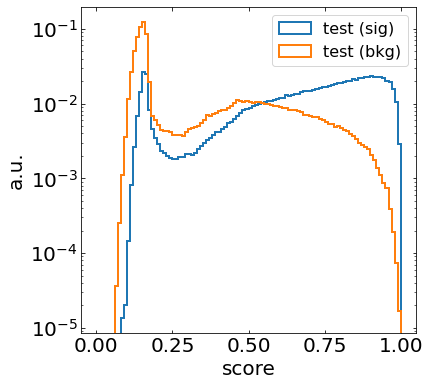

In [16]:
fig, axes = plt.subplots(figsize=(6, 6))

bins = np.linspace(0, 1, 101)

test_n_true = np.sum(test_df.truth == 1)
test_n_false = np.sum(test_df.truth == 0)
axes.hist(
    test_df[test_df.truth == 1].score, 
    weights=np.ones(test_n_true)/test_n_true, 
    bins=bins,
    histtype="step",
    linewidth=2,
    label="test (sig)"
);
axes.hist(
    test_df[test_df.truth == 0].score, 
    weights=np.ones(test_n_false)/test_n_false, 
    bins=bins,
    histtype="step",
    linewidth=2,
    label="test (bkg)"
);
axes.set_yscale("log");
axes.legend(fontsize=16)

axes.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
axes.set_xlabel("score", size=20);
axes.set_ylabel("a.u.", size=20);

----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Loading /blue/p.chang/jguiang/data/vbsvvh/Gaussians3D_PRL_dCorr/models/Gaussians3D_PRL_dCorr_modelNeuralNetwork_nhidden3_hiddensize128_lrConstantLR0.001_discolambda1000_epoch100_model.pt
----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

/scratch/local/63821947/ipykernel_1471/2844281582.py:77: RuntimeWarning: invalid value encountered in true_divide
  avg_infer_X1 = X1binned_infer_sum/X1binned


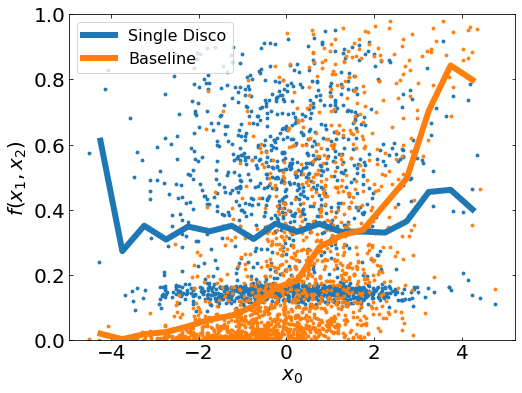

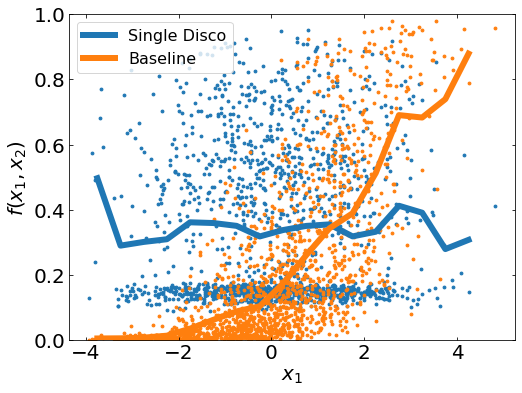

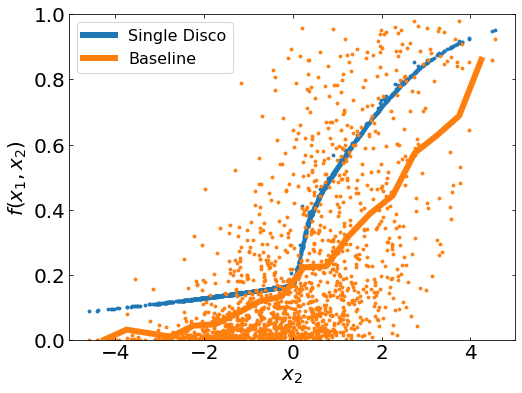

In [17]:
import torch
import models

def smart_clip(np_array, bins):
    clip_low = 0.5 * (bins[0] + bins[1])
    clip_high = 0.5 * (bins[-2] + bins[-1])
    return np.clip(np_array, clip_low, clip_high)

n_events = 1500

mean_bkg = np.array([0, 0, 0])
variance_bkg = 1.5
covariance_bkg = np.array([
    [ 1.0,  0.8, 0.0],
    [ 0.8,  1.0, 0.0],
#     [ 1.0, -0.8, 0.0],
#     [-0.8,  1.0, 0.0],
    [ 0.0,  0.0, 1.0]
])*(variance_bkg**2)
rng = np.random.default_rng()
bkg = rng.multivariate_normal(mean_bkg, covariance_bkg, n_events)

# mean_sig = np.array([2.5, 2.5, 2])
# variance_sig = 1.5
# covariance_sig = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1]
# ])*(variance_sig)**2

epoch = 100
nodisco_epoch = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model = getattr(models, config.model.name)
model = Model.from_config(config).to(device)
saved_model = train.get_outfile(config, epoch=epoch, tag="model", subdir="models", msg="Loading {}")
model.load_state_dict(torch.load(saved_model, map_location=device))
model.eval()

# nodisco_config = VBSConfig.from_json("configs/Gaussian_noDisCo.json")
# nodisco_config = VBSConfig.from_json("configs/Gaussian_2_noDisCo.json")
nodisco_config = VBSConfig.from_json("configs/Gaussians3D_PRL_Baseline_posCov.json")
nodisco_model = Model.from_config(nodisco_config).to(device)
nodisco_saved_model = train.get_outfile(nodisco_config, epoch=nodisco_epoch, tag="model", subdir="models", msg="Loading {}")
nodisco_model.load_state_dict(torch.load(nodisco_saved_model, map_location=device))
nodisco_model.eval()

def plot(model, bkg, color, label, fig=None, axes=None):
    if fig and axes:
        axes0, axes1, axes2 = axes
    else:
        fig, axes0 = plt.subplots(figsize=(8,6))
        fig, axes1 = plt.subplots(figsize=(8,6))
        fig, axes2 = plt.subplots(figsize=(8,6))

    inferences = []
    for features in bkg:
        X0, X1, X2 = features
        inference = model(torch.tensor([X1, X2], dtype=torch.float)).item()
        axes0.scatter(X0, inference, color=color, s=8)
        axes1.scatter(X1, inference, color=color, s=8)
        axes2.scatter(X2, inference, color=color, s=8)
        inferences.append(inference)

    X_bins = np.linspace(-5, 5, 21)
    X_centers = 0.5*(X_bins[1:] + X_bins[:-1])

    X0binned_infer_sum, _ = np.histogram(smart_clip(bkg.T[0], X_bins), bins=X_bins, weights=inferences)
    X0binned, _ = np.histogram(bkg.T[0], bins=X_bins)
    avg_infer_X0 = X0binned_infer_sum/X0binned
    axes0.plot(X_centers[1:-1], avg_infer_X0[1:-1], linewidth=6, label=label, color=color)

    X1binned_infer_sum, _ = np.histogram(smart_clip(bkg.T[1], X_bins), bins=X_bins, weights=inferences)
    X1binned, _ = np.histogram(bkg.T[1], bins=X_bins)
    avg_infer_X1 = X1binned_infer_sum/X1binned
    axes1.plot(X_centers[1:-1], avg_infer_X1[1:-1], linewidth=6, label=label, color=color)

    if label == "Baseline":
        X2binned_infer_sum, _ = np.histogram(smart_clip(bkg.T[2], X_bins), bins=X_bins, weights=inferences)
        X2binned, _ = np.histogram(bkg.T[2], bins=X_bins)
        avg_infer_X2 = X2binned_infer_sum/X2binned
        axes2.plot(X_centers[1:-1], avg_infer_X2[1:-1], linewidth=6, label=label, color=color)
    else:
        axes2.plot([], [], linewidth=6, label=label, color=color)

    axes0.set_ylim(bottom=0, top=1)
    axes0.set_ylabel(r"$f(x_1, x_2)$", size=20);
    axes0.set_xlabel(r"$x_0$", size=20);
    axes0.legend(fontsize=16);
    axes0.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
    axes1.set_ylim(bottom=0, top=1)
    axes1.set_ylabel(r"$f(x_1, x_2)$", size=20);
    axes1.set_xlabel(r"$x_1$", size=20);
    axes1.legend(fontsize=16);
    axes1.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
    axes2.set_ylim(bottom=0, top=1)
    axes2.set_ylabel(r"$f(x_1, x_2)$", size=20);
    axes2.set_xlabel(r"$x_2$", size=20);
    axes2.legend(fontsize=16);
    axes2.tick_params(axis="both", which="both", direction="in", labelsize=20, top=True, right=True)
    

fig, axes0 = plt.subplots(figsize=(8,6))
fig, axes1 = plt.subplots(figsize=(8,6))
fig, axes2 = plt.subplots(figsize=(8,6))

plot(model, bkg, "C0", "Single Disco", fig=fig, axes=[axes0, axes1, axes2])
plot(nodisco_model, bkg, "C1", "Baseline", fig=fig, axes=[axes0, axes1, axes2])

Text(0, 0.5, 'X2')

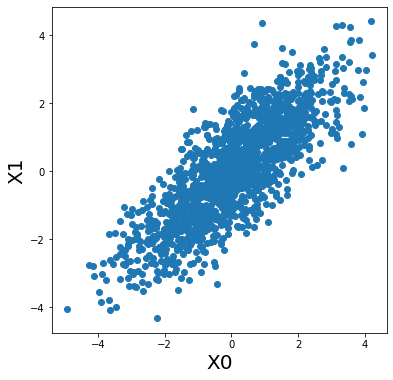

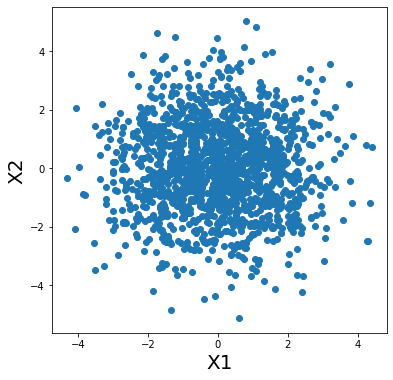

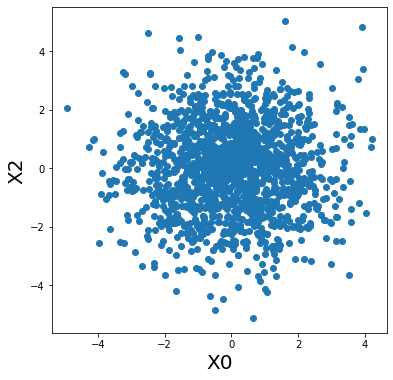

In [18]:
n_events = 1500

mean_bkg = np.array([0, 0, 0])
variance_bkg = 1.5
covariance_bkg = np.array([
#     [ 1.0, -0.8, 0.0],
#     [-0.8,  1.0, 0.0],
    [ 1.0,  0.8, 0.0],
    [ 0.8,  1.0, 0.0],
    [ 0.0,  0.0, 1.0]
])*(variance_bkg**2)
rng = np.random.default_rng()
bkg = rng.multivariate_normal(mean_bkg, covariance_bkg, n_events)


fig, axes0 = plt.subplots(figsize=(6, 6))
fig, axes1 = plt.subplots(figsize=(6, 6))
fig, axes2 = plt.subplots(figsize=(6, 6))

axes0.scatter(bkg.T[0], bkg.T[1])
axes0.set_xlabel("X0", size=20)
axes0.set_ylabel("X1", size=20)

axes1.scatter(bkg.T[1], bkg.T[2])
axes1.set_xlabel("X1", size=20)
axes1.set_ylabel("X2", size=20)

axes2.scatter(bkg.T[0], bkg.T[2])
axes2.set_xlabel("X0", size=20)
axes2.set_ylabel("X2", size=20)

Text(0, 0.5, 'X2')

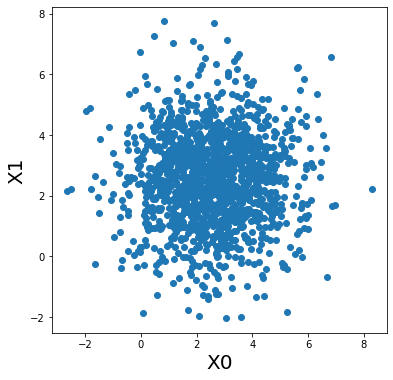

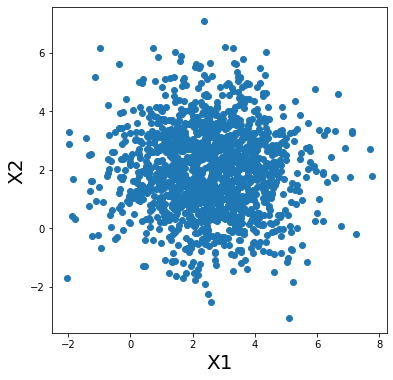

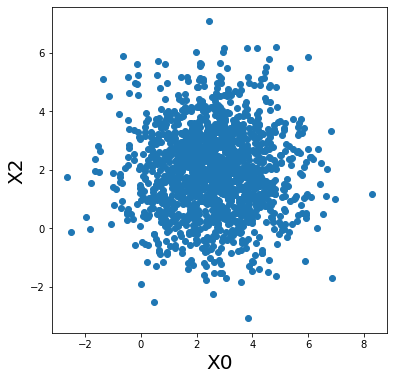

In [19]:
n_events = 1500

mean_sig = np.array([2.5, 2.5, 2])
variance_sig = 1.5
covariance_sig = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])*(variance_sig)**2
rng = np.random.default_rng()
sig = rng.multivariate_normal(mean_sig, covariance_sig, n_events)


fig, axes0 = plt.subplots(figsize=(6, 6))
fig, axes1 = plt.subplots(figsize=(6, 6))
fig, axes2 = plt.subplots(figsize=(6, 6))

axes0.scatter(sig.T[0], sig.T[1])
axes0.set_xlabel("X0", size=20)
axes0.set_ylabel("X1", size=20)

axes1.scatter(sig.T[1], sig.T[2])
axes1.set_xlabel("X1", size=20)
axes1.set_ylabel("X2", size=20)

axes2.scatter(sig.T[0], sig.T[2])
axes2.set_xlabel("X0", size=20)
axes2.set_ylabel("X2", size=20)